In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cdflib 
from cdflib import cdfepoch
from pathlib import Path
import pickle
from datetime import date

In [84]:
#ACCファイルの変数名を確認
cdf = cdflib.CDF("data/swarm/2020_ACC/SW_OPER_DNSCACC_2__20200216T000000_20200216T235950_0201.cdf")

info = cdf.cdf_info()
print("rVariables:", info.rVariables)
print("zVariables:", info.zVariables)
print(info)

rVariables: []
zVariables: ['time', 'density', 'altitude', 'latitude', 'longitude', 'local_solar_time']
CDFInfo(CDF=PosixPath('/workspace/data/swarm/2020_ACC/SW_OPER_DNSCACC_2__20200216T000000_20200216T235950_0201.cdf'), Version='3.6.3', Encoding=6, Majority='Row_major', rVariables=[], zVariables=['time', 'density', 'altitude', 'latitude', 'longitude', 'local_solar_time'], Attributes=[{'TITLE': 'Global'}, {'ORIGINAL_PRODUCT_NAME': 'Global'}, {'CREATOR': 'Global'}, {'TIME SYSTEM': 'Global'}, {'VARIABLE DESCRIPTION': 'Variable'}, {'UNITS': 'Variable'}, {'FORMAT': 'Variable'}, {'FILLVAL': 'Variable'}, {'SATELLITE': 'Global'}, {'DESCRIPTION': 'Global'}, {'DAILY_QUALITY_INDEX': 'Global'}], Copyright='\nCommon Data Format (CDF)\n(C) Copyright 1990-2016 NASA/GSFC\nSpace Physics Data Facility\nNASA/Goddard Space Flight Center\nGreenbelt, Maryland 20771 USA\n(Internet -- GSFC-CDF-SUPPORT@LISTS.NASA.GOV)\n', Checksum=False, Num_rdim=0, rDim_sizes=[], Compressed=False, LeapSecondUpdate=None)


In [85]:
#PODファイルの変数名を確認
cdf = cdflib.CDF("data/swarm/2020_POD/SW_OPER_DNSCPOD_2__20200216T000000_20200216T235930_0201.cdf")
info = cdf.cdf_info()
print("rVariables:", info.rVariables)
print("zVariables:", info.zVariables)
print(info)

rVariables: []
zVariables: ['time', 'density', 'density_orbitmean', 'validity_flag', 'altitude', 'latitude', 'longitude', 'local_solar_time']
CDFInfo(CDF=PosixPath('/workspace/data/swarm/2020_POD/SW_OPER_DNSCPOD_2__20200216T000000_20200216T235930_0201.cdf'), Version='3.6.3', Encoding=6, Majority='Row_major', rVariables=[], zVariables=['time', 'density', 'density_orbitmean', 'validity_flag', 'altitude', 'latitude', 'longitude', 'local_solar_time'], Attributes=[{'TITLE': 'Global'}, {'ORIGINAL_PRODUCT_NAME': 'Global'}, {'CREATOR': 'Global'}, {'TIME SYSTEM': 'Global'}, {'VARIABLE DESCRIPTION': 'Variable'}, {'UNITS': 'Variable'}, {'FORMAT': 'Variable'}, {'FILLVAL': 'Variable'}, {'SATELLITE': 'Global'}, {'DESCRIPTION': 'Global'}, {'ORBITAL_PERIOD_SECONDS': 'Global'}], Copyright='\nCommon Data Format (CDF)\n(C) Copyright 1990-2016 NASA/GSFC\nSpace Physics Data Facility\nNASA/Goddard Space Flight Center\nGreenbelt, Maryland 20771 USA\n(Internet -- GSFC-CDF-SUPPORT@LISTS.NASA.GOV)\n', Checksum=

In [86]:
f = Path("data") / "swarm" / "2020_POD" / "SW_OPER_DNSCPOD_2__20200216T000000_20200216T235930_0201.cdf"
cdf = cdflib.CDF(str(f))

# density 変数の属性を表示
print(cdf.varattsget("density"))

print(cdf.varattsget("altitude"))

{'VARIABLE DESCRIPTION': 'Density derived from GPS accelerations (FAST)', 'UNITS': 'kg/m3', 'FORMAT': 'E16.9', 'FILLVAL': '0.99900E+33'}
{'VARIABLE DESCRIPTION': 'Altitude', 'UNITS': 'm', 'FORMAT': 'E16.9', 'FILLVAL': '0.99900E+33'}


In [87]:
#pandasDataFrameにすることによって時系列データを扱える
#cdf→DataFrameをするための関数を定義
def read_cdf_to_df(path: Path, time_var="time", var_map=None) -> pd.DataFrame:
    """
    CDFを読み、index=time（UTC）、列に var_map で指定した変数を入れた DataFrame を返す。
    var_map: {出力列名: CDF変数名}
    """
    #cdfファイル読み取り
    c = cdflib.CDF(str(path))
    #時刻配列を Datetime に変換し、DataFrameIndex にする
    t = pd.to_datetime(cdfepoch.to_datetime(c.varget(time_var)))  # UTC naive
    df = pd.DataFrame(index=pd.DatetimeIndex(t, name="time"))
    
    if var_map:
        for out, var in var_map.items():
            arr = np.asarray(c.varget(var))
            if arr.ndim == 1 and len(arr) == len(df):
                # --- ここから: FILLVAL を NaN に ---
                try:
                    atts = c.varattsget(var)
                    fill = atts.get("FILLVAL", None)
                    if isinstance(fill, str):
                        # "0.99900E+33" のような文字列も欠損値とする
                        fill = float(fill.replace("D", "E"))
                    if fill is not None:
                        arr = np.where(arr == fill, np.nan, arr)
                    # 念のため、1e30 以上は欠損扱いとした
                    arr = np.where(arr > 1e30, np.nan, arr)
                except Exception:
                    pass
                # --- ここまで ---
                df[out] = arr
    return df.sort_index()

def bin_one_day(df: pd.DataFrame, date: str, secs: int, cols: list) -> pd.DataFrame:
    """
    指定日のデータを 'secs' 秒間隔の等間隔グリッドに詰め直す。
    例) POD: secs=30 -> 2880点, ACC: secs=10 -> 8640点
    cols: グリッド化対象の列名（例: ['density','altitude', ...]）
    """
    day = pd.to_datetime(date).date()
    d = df.loc[df.index.date == day].copy()
    if d.empty:
        # 空でも正しい長さのNaNで返す
        start = pd.Timestamp(str(day))
        idx = pd.date_range(start, start + pd.Timedelta(days=1) - pd.Timedelta(seconds=secs), freq=f"{secs}S")
        out = pd.DataFrame(index=idx, columns=cols, dtype=float)
        return out

    # その日の秒（00:00:00 からの経過秒）
    sec_of_day = (d.index - pd.Timestamp(str(day))).total_seconds()
    # どのバケット（0..n_bins-1）に入るか
    bin_idx = np.floor_divide(sec_of_day + secs/2, secs).astype(int)  # 最近傍に丸め
    n_bins = int(24*3600 // secs)

    # グリッドの時間軸
    start = pd.Timestamp(str(day))
    grid_index = pd.date_range(start, start + pd.Timedelta(days=1) - pd.Timedelta(seconds=secs), freq=f"{secs}s")

    # 初期化（NaNで満たす）
    out = pd.DataFrame(index=grid_index, columns=cols, dtype=float)

    # 同じバケットに複数サンプルが来た場合は平均（お好みで最新値などに変更可）
    for c in cols:
        tmp = pd.DataFrame({"bin": bin_idx, c: d[c].to_numpy(dtype=float)})
        grouped = tmp.groupby("bin")[c].mean()  # 代表値の定義：平均
        valid_bins = grouped.index[(grouped.index >= 0) & (grouped.index < n_bins)]
        out.loc[out.index[valid_bins], c] = grouped.loc[valid_bins].values

    return out

In [88]:

# === 設定 ===
CHOICE = "POD"   # "POD" か "ACC"
YEAR   = 2020    # 先生コードと同じ条件
ROOT   = Path("data")  # あなたの data/ のルート

# === ファイル探索 ===
if CHOICE.upper() == "POD":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "POD" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
        "validity_flag": "validity_flag",
        "density_orbitmean": "density_orbitmean",
    }
    bin_secs = 30      # 30秒 -> 2880点
elif CHOICE.upper() == "ACC":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "ACC" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
    }
    bin_secs = 10      # 10秒 -> 8640点
else:
    raise ValueError("CHOICE must be 'POD' or 'ACC'")

print(f"Found {len(files)} {CHOICE} files in {YEAR}")

# === 読み込み & 日単位グリッド化 → DNS 辞書に格納 ===
DNS = {}  # {doy: DataFrame(columns=cols + meta)}

for f in files:
    # ファイル→DF
    df = read_cdf_to_df(f, time_var="time", var_map=var_map)

    # POD: validity_flagがあればフィルタ（1を有効と想定）
    CHOICE = "POD"
    YEAR = 2020

    # ファイル内に含まれるユニークな日を順に処理
    for date in sorted({ts.date() for ts in df.index}):
        date_str = str(date)
        # 欲しい列（DNSに入れたいコア項目）
        cols = [c for c in ["density","altitude","latitude","longitude","local_solar_time","validity_flag","density_orbitmean"] if c in df.columns]
        binned = bin_one_day(df, date_str, secs=bin_secs, cols=cols)

        # doy を MATLAB と同様に 1始まりで計算
        doy = (pd.Timestamp(date_str) - pd.Timestamp(f"{YEAR}-01-01")).days + 1

        # T（先生コードの day-of-year 小数日）相当を入れるなら：
        # 小数日 = (doy-1) + (経過秒 / 86400)
        seconds = (binned.index - pd.Timestamp(date_str)).total_seconds()
        T = (doy - 1) + seconds / 86400.0

        # ymd は [Y M D h m s] を入れたい場合
        ymd = np.column_stack([
            np.full(len(binned), int(date_str[:4])),
            np.full(len(binned), int(date_str[5:7])),
            np.full(len(binned), int(date_str[8:10])),
            binned.index.hour, binned.index.minute, binned.index.second
        ])

        # DNS[doy] を DataFrame で持つ（先生の構造体に相当）
        out = binned.copy()
        out["T"] = T
        # 必要なら ymd は別管理でもOK（ここでは別キーに入れる）
        DNS[doy] = {"data": out, "ymd": ymd, "date": date_str}

print(f"Days collected: {len(DNS)}")

# === 保存 ===
# Python（pickle）
import pickle
save_path = Path(f"DNS_{CHOICE}_{YEAR}.pkl")
with open(save_path, "wb") as f:
    pickle.dump(DNS, f)
print("Saved:", save_path)


Found 121 POD files in 2020
Days collected: 121
Saved: DNS_POD_2020.pkl


In [89]:
# === 設定 ===
CHOICE = "ACC"   # "POD" か "ACC"
YEAR   = 2020    # 先生コードと同じ条件
ROOT   = Path("data")  # あなたの data/ のルート

# === ファイル探索 ===
if CHOICE.upper() == "POD":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "POD" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
        "validity_flag": "validity_flag",
        "density_orbitmean": "density_orbitmean",
    }
    bin_secs = 30      # 30秒 -> 2880点
elif CHOICE.upper() == "ACC":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "ACC" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
    }
    bin_secs = 10      # 10秒 -> 8640点
else:
    raise ValueError("CHOICE must be 'POD' or 'ACC'")

print(f"Found {len(files)} {CHOICE} files in {YEAR}")

# === 読み込み & 日単位グリッド化 → DNS 辞書に格納 ===
DNS = {}  # {doy: DataFrame(columns=cols + meta)}

for f in files:
    # ファイル→DF
    df = read_cdf_to_df(f, time_var="time", var_map=var_map)

    # POD: validity_flagがあればフィルタ（1を有効と想定）
    CHOICE = "POD"
    YEAR = 2020

    # ファイル内に含まれるユニークな日を順に処理
    for date in sorted({ts.date() for ts in df.index}):
        date_str = str(date)
        # 欲しい列（DNSに入れたいコア項目）
        cols = [c for c in ["density","altitude","latitude","longitude","local_solar_time","validity_flag","density_orbitmean"] if c in df.columns]
        binned = bin_one_day(df, date_str, secs=bin_secs, cols=cols)

        # doy を MATLAB と同様に 1始まりで計算
        doy = (pd.Timestamp(date_str) - pd.Timestamp(f"{YEAR}-01-01")).days + 1

        # T（先生コードの day-of-year 小数日）相当を入れるなら：
        # 小数日 = (doy-1) + (経過秒 / 86400)
        seconds = (binned.index - pd.Timestamp(date_str)).total_seconds()
        T = (doy - 1) + seconds / 86400.0

        # ymd は [Y M D h m s] を入れたい場合
        ymd = np.column_stack([
            np.full(len(binned), int(date_str[:4])),
            np.full(len(binned), int(date_str[5:7])),
            np.full(len(binned), int(date_str[8:10])),
            binned.index.hour, binned.index.minute, binned.index.second
        ])

        # DNS[doy] を DataFrame で持つ（先生の構造体に相当）
        out = binned.copy()
        out["T"] = T
        # 必要なら ymd は別管理でもOK（ここでは別キーに入れる）
        DNS[doy] = {"data": out, "ymd": ymd, "date": date_str}

print(f"Days collected: {len(DNS)}")

# === 保存===
# Python（pickle）
save_path = Path(f"DNS_ACC_{YEAR}.pkl")
with open(save_path, "wb") as f:
    pickle.dump(DNS, f)
print("Saved:", save_path)

Found 75 ACC files in 2020
Days collected: 75
Saved: DNS_ACC_2020.pkl


In [90]:
from datetime import date

k = (date(2020,2,16) - date(2020,1,1)).days + 1
print(DNS_POD[k]["data"].head())

                          density       altitude   latitude  longitude  \
2020-02-16 00:00:00  3.392699e-14  436585.890104  30.913148  32.537153   
2020-02-16 00:00:30  2.804285e-14  436853.813673  32.847714  32.535136   
2020-02-16 00:01:00  2.218418e-14  437144.423965  34.781536  32.538580   
2020-02-16 00:01:30  1.649032e-14  437455.438470  36.714574  32.548170   
2020-02-16 00:02:00  1.093662e-14  437784.471408  38.646789  32.564683   

                     local_solar_time  validity_flag  density_orbitmean  \
2020-02-16 00:00:00          1.933607            0.0       1.207250e-13   
2020-02-16 00:00:30          1.941806            0.0       1.208599e-13   
2020-02-16 00:01:00          1.950369            0.0       1.209955e-13   
2020-02-16 00:01:30          1.959342            0.0       1.211308e-13   
2020-02-16 00:02:00          1.968777            0.0       1.212650e-13   

                             T  
2020-02-16 00:00:00  46.000000  
2020-02-16 00:00:30  46.000347  
2020-

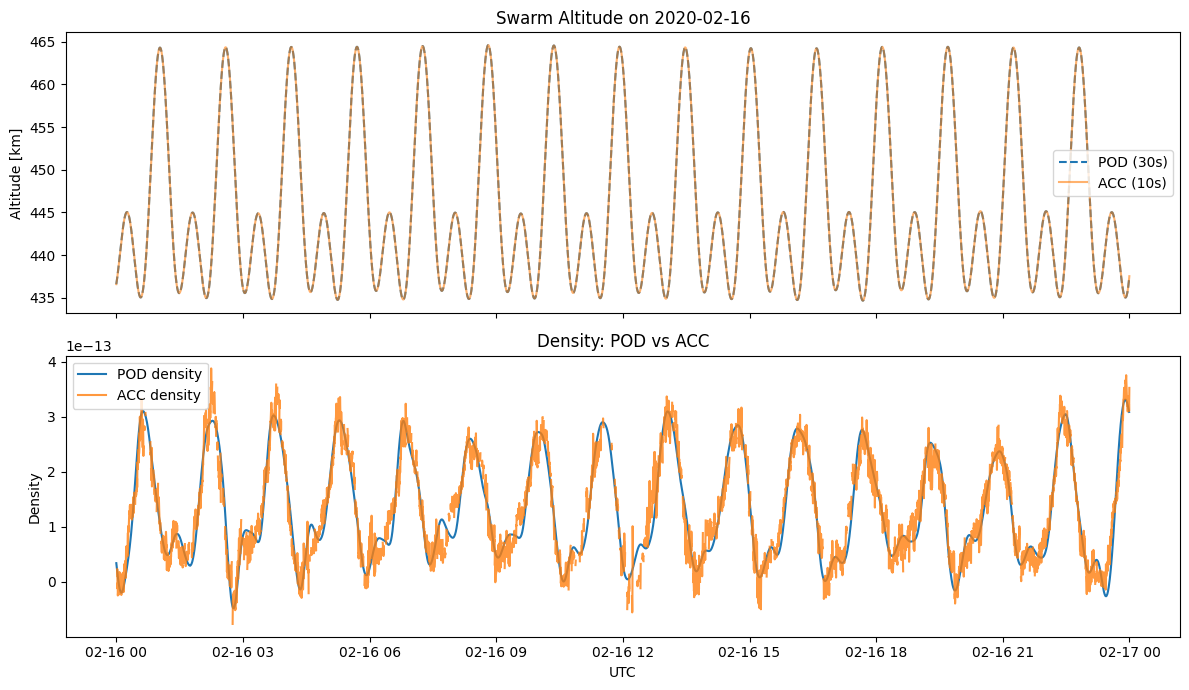

In [91]:
import datetime
# 読み込み
DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))

# 日付→DOY（2020基準）
def doy(dt):
    return (dt - datetime.date(2020,1,1)).days + 1

the_day = datetime.date(2020,2,16)
k = doy(the_day)

P = DNS_POD[k]["data"]
A = DNS_ACC[k]["data"]

# --- Plot ---
fig, axes = plt.subplots(2,1,figsize=(12,7),sharex=True)

# 高度を km に変換してからプロット
axes[0].plot(P.index, P["altitude"]/1000, label="POD (30s)", linestyle="--")
axes[0].plot(A.index, A["altitude"]/1000, alpha=0.6, label="ACC (10s)", linestyle="-")
axes[0].set_ylabel("Altitude [km]")
axes[0].set_title(f"Swarm Altitude on {the_day}")
axes[0].legend()

# 密度
axes[1].plot(P.index, P["density"], label="POD density")
axes[1].plot(A.index, A["density"], alpha=0.8, label="ACC density")
axes[1].set_ylabel("Density")
axes[1].set_title("Density: POD vs ACC")
axes[1].legend()

plt.xlabel("UTC")
plt.tight_layout()
plt.show()

In [122]:
import datetime
#関数定義
# 2020年のDNS（POD/ACC）を読み込み　、monthlyで見たい時に月毎で取り出す用
DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))

def doy_2020(d: date) -> int:
    """2020-01-01 を 1 とする DOY（1始まり）"""
    return (d - date(2020,1,1)).days + 1

def day_df(DNS: dict, d: date, colname: str):
    k = doy_2020(d)
    if k not in DNS: return pd.DataFrame()
    df = DNS[k]["data"]
    # その日のみ抽出（UTC）
    start = pd.Timestamp(d.year, d.month, d.day)
    end   = start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    return df.loc[start:end].rename(columns={"density": colname}).sort_index()

def plot_days(dates, tolerance="30s", resample=None, sharey=True):
    n = len(dates)
    fig, axes = plt.subplots(n, 1, figsize=(14, 3.5*n), sharex=False, sharey=sharey)

    if n == 1:
        axes = [axes]
        packs = []
        for d in dates:
            P = day_df(DNS_POD, d, "rho_pod")
            A = day_df(DNS_ACC, d, "rho_acc")
            if P.empty or A.empty:
                packs.append((d, pd.DataFrame()))
                continue
                M = pd.merge_asof(P[["rho_pod"]],
                                  A[["rho_acc"]],
                                left_index=True, right_index=True,
                                direction="nearest", tolerance=pd.Timedelta(tolerance))
                if resample:
                    M = M.resample(resample).mean()
                    packs.append((d, M))

def concat_dns_range(DNS: dict, start, end, cols=None) -> pd.DataFrame:
    """
    DNS（{doy: {"data": DataFrame, ...}}）から、任意の期間[start, end]のデータを縦結合して返す。
    - start/end は str / pandas.Timestamp / datetime / date のいずれでもOK（UTC前提のnaiveで扱う）
    - cols に列名リストを渡すと、その列だけ抽出
    返り値：時刻昇順の DataFrame（存在しなければ空 DataFrame）
    """
    # 型をそろえる（endは一日の終端まで含む）
    start_ts = pd.to_datetime(start)
    end_ts   = pd.to_datetime(end)
    # もし end が日付だけなら 23:59:59.999999 まで含める
    if isinstance(end, (date, datetime.date)) and getattr(end, "hour", 0) == 0 and getattr(end, "minute", 0) == 0 and getattr(end, "second", 0) == 0:
        end_ts = end_ts.replace(hour=23, minute=59, second=59, microsecond=999999)

    frames = []
    for k in sorted(DNS.keys()):
        df = DNS[k].get("data")
        if df is None or df.empty:
            continue
        # 期間でスライス
        cut = df.loc[start_ts:end_ts]
        if not cut.empty:
            frames.append(cut[cols] if cols else cut)

    return pd.concat(frames).sort_index() if frames else pd.DataFrame()



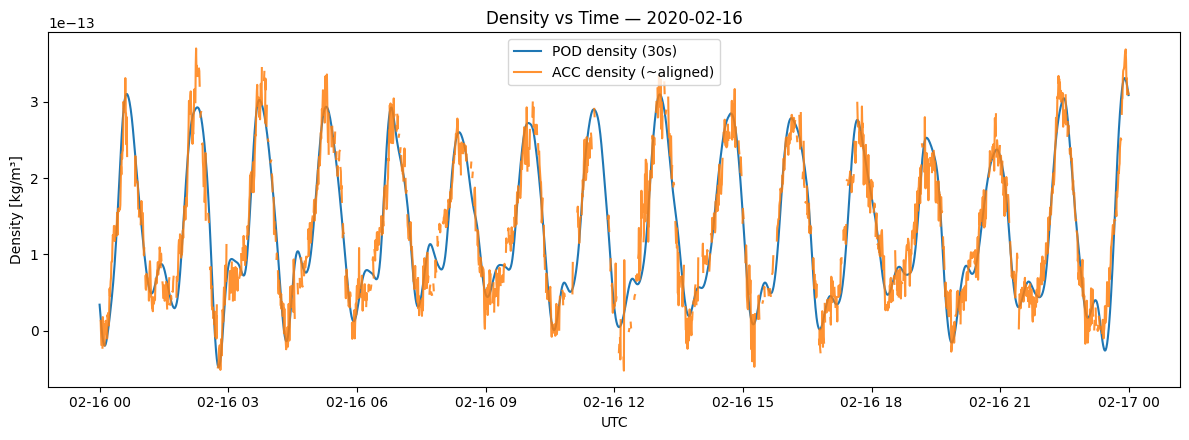

In [123]:
#日にちごとで見るグラフプロット、1日間で見る場合
from datetime import date
# === 解析したい日付 ===
the_day = date(2020, 2, 16)  # ← 好きな日に変更

k = doy_2020(the_day)
P = DNS_POD.get(k, {}).get("data")
A = DNS_ACC.get(k, {}).get("data")

if P is None or A is None:
    raise ValueError(f"DNS に {the_day} の日が見つかりません（POD/ACCのどちらか欠け）")

# POD基準でACC密度を合わせる（±30s）
merged = pd.merge_asof(
    P.sort_index()[["density"]].rename(columns={"density":"rho_pod"}),
    A.sort_index()[["density"]].rename(columns={"density":"rho_acc"}),
    left_index=True, right_index=True,
    direction="nearest", tolerance=pd.Timedelta("30s")
)

fig, ax = plt.subplots(figsize=(12,4.5))
ax.plot(merged.index, merged["rho_pod"], label="POD density (30s)")
ax.plot(merged.index, merged["rho_acc"], label="ACC density (~aligned)", alpha=0.85)
ax.set_title(f"Density vs Time — {the_day.isoformat()}")
ax.set_ylabel("Density [kg/m³]")
ax.set_xlabel("UTC")
ax.legend()
plt.tight_layout(); plt.show()


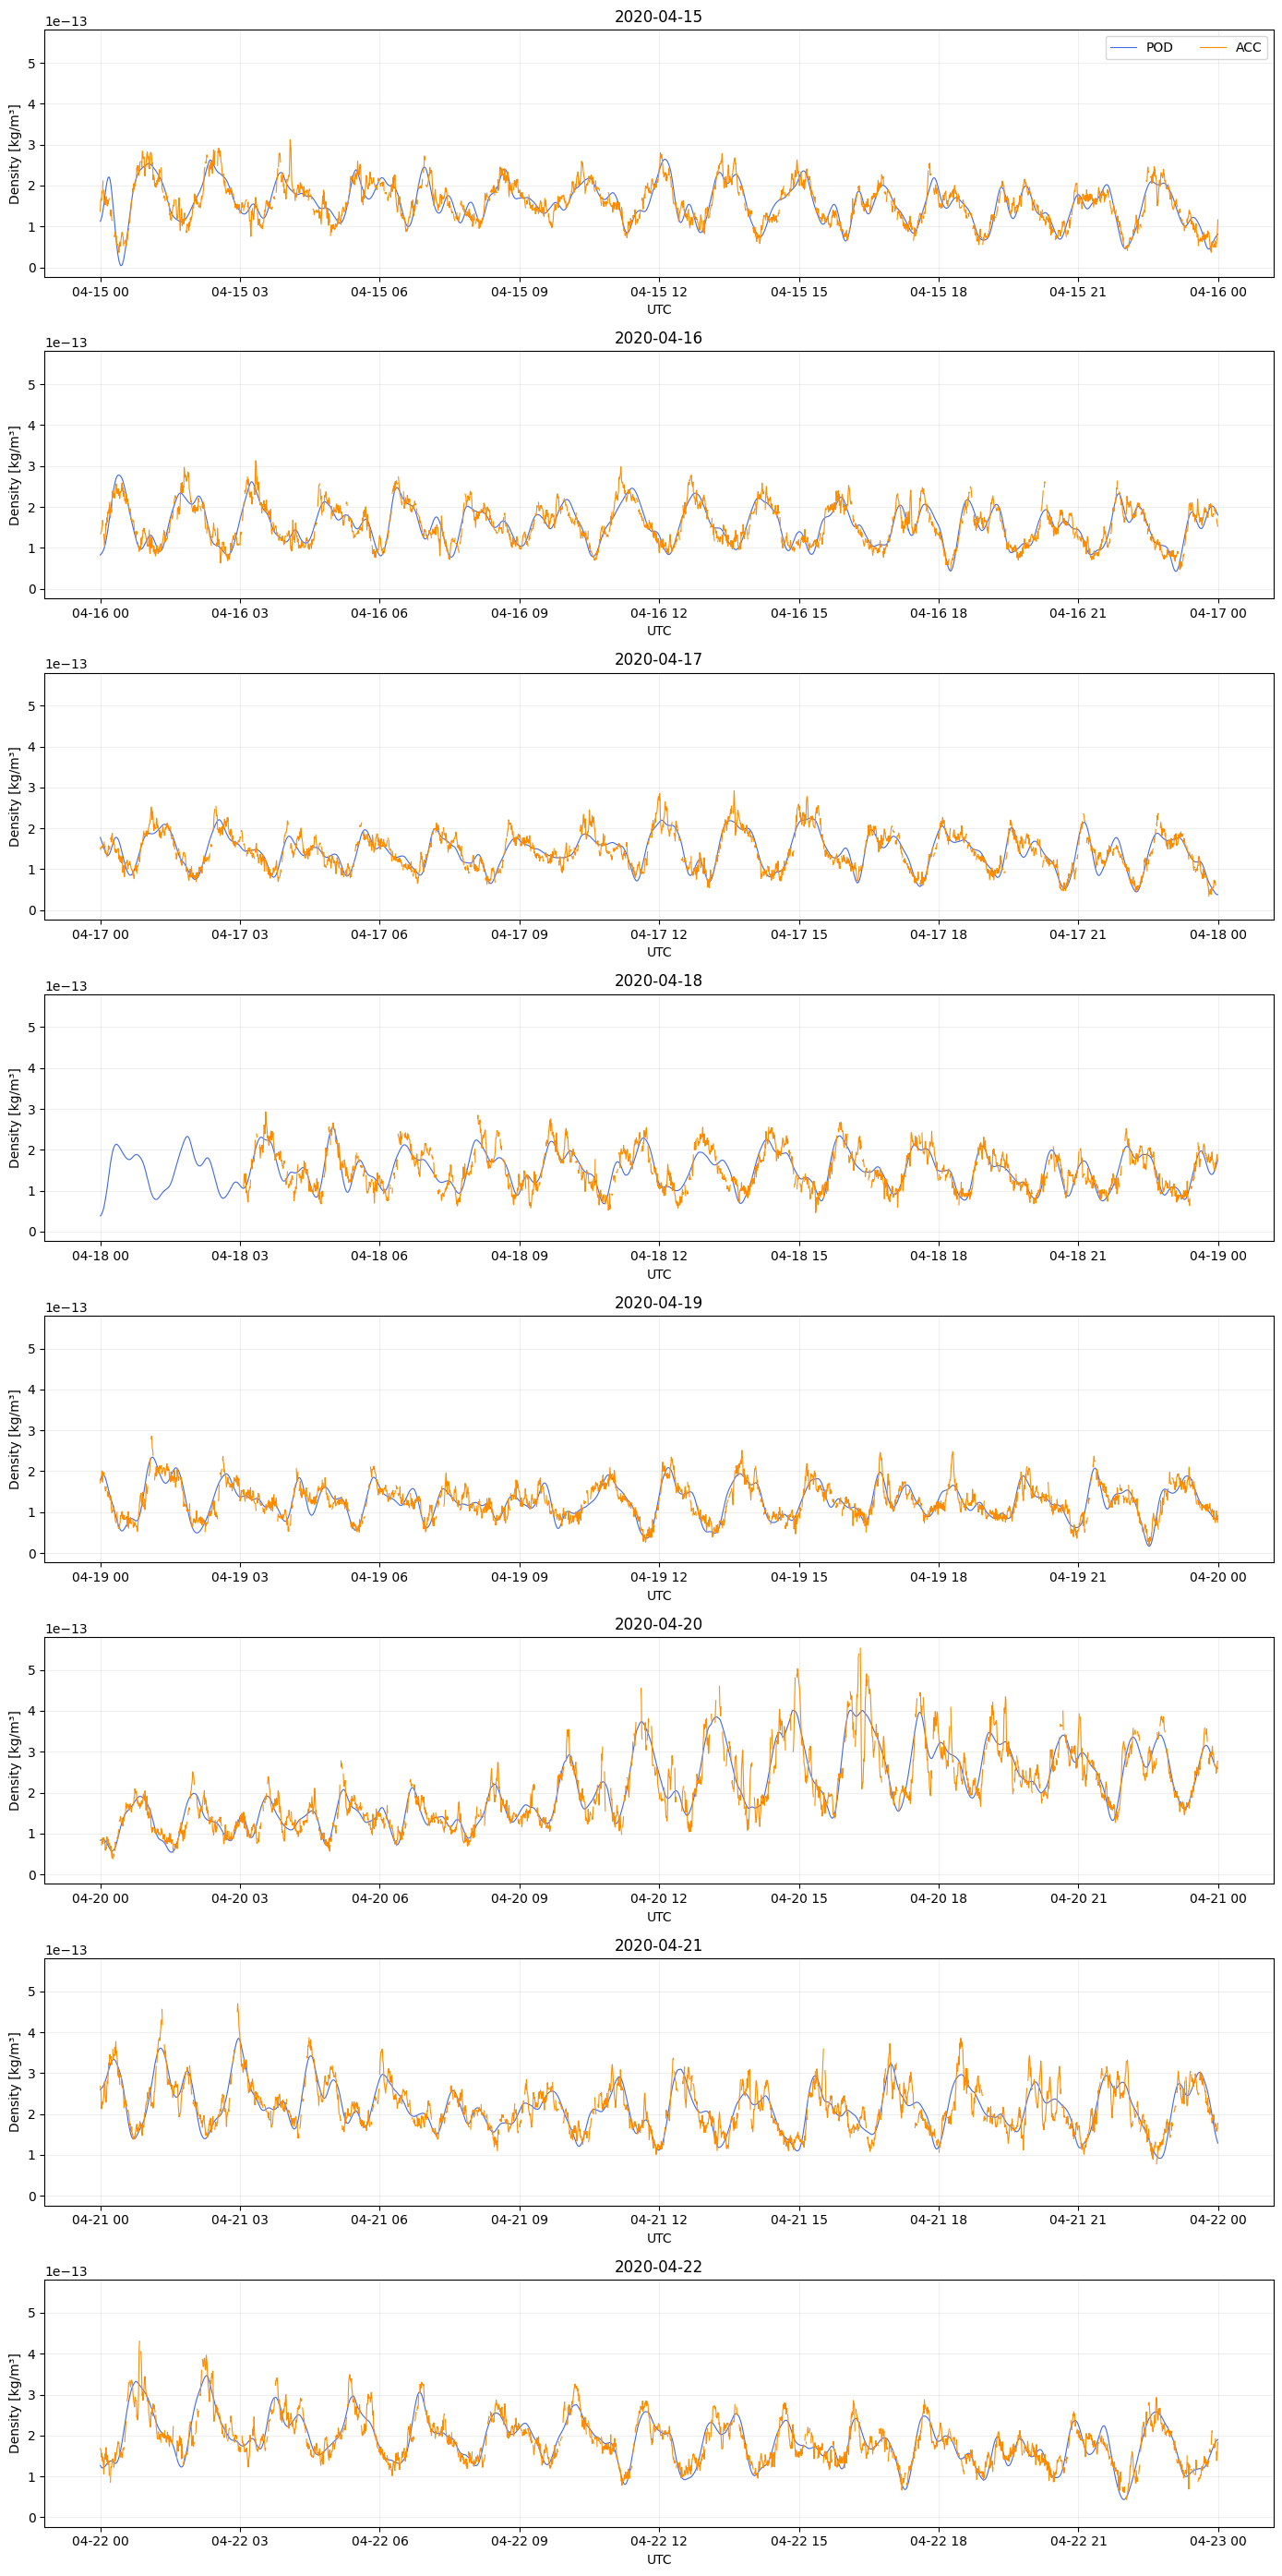

In [124]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import pandas as pd

def plot_days(dates, tolerance="30s", resample=None, sharey=True):
    n = len(dates)
    fig, axes = plt.subplots(n, 1, figsize=(14, 3.5*n),
                             sharex=False, sharey=sharey)
    if n == 1:
        axes = [axes]

    for ax, d in zip(axes, dates):
        P = day_df(DNS_POD, d, "rho_pod")
        A = day_df(DNS_ACC, d, "rho_acc")

        if P.empty or A.empty:
            ax.set_title(f"{d.isoformat()} (no data)")
            ax.set_xlabel("UTC")
            continue

        M = pd.merge_asof(
            P[["rho_pod"]], A[["rho_acc"]],
            left_index=True, right_index=True,
            direction="nearest", tolerance=pd.Timedelta(tolerance)
        )
        if resample:
            M = M.resample(resample).mean()

        ax.plot(M.index, M["rho_pod"], color="royalblue", linewidth=0.8, label="POD")
        ax.plot(M.index, M["rho_acc"], color="darkorange", linewidth=0.8, label="ACC")
        ax.set_title(d.isoformat())
        ax.set_ylabel("Density [kg/m³]")
        ax.grid(alpha=0.2)
        if ax is axes[0]:
            ax.legend(ncol=2)
        ax.set_xlabel("UTC")

    plt.tight_layout()
    plt.show()


def plot_days_range(start: date, end: date, tolerance="30s", resample=None, sharey=True):
    """start から end までの日付を自動生成して plot_days に渡す"""
    dates = [start + timedelta(days=i) for i in range((end - start).days + 1)]
    plot_days(dates, tolerance=tolerance, resample=resample, sharey=sharey)
# 例：2020/4/16〜2020/4/22 の1週間を表示
plot_days_range(date(2020,4,15), date(2020,4,22),
                tolerance="30s", resample=None, sharey=True)


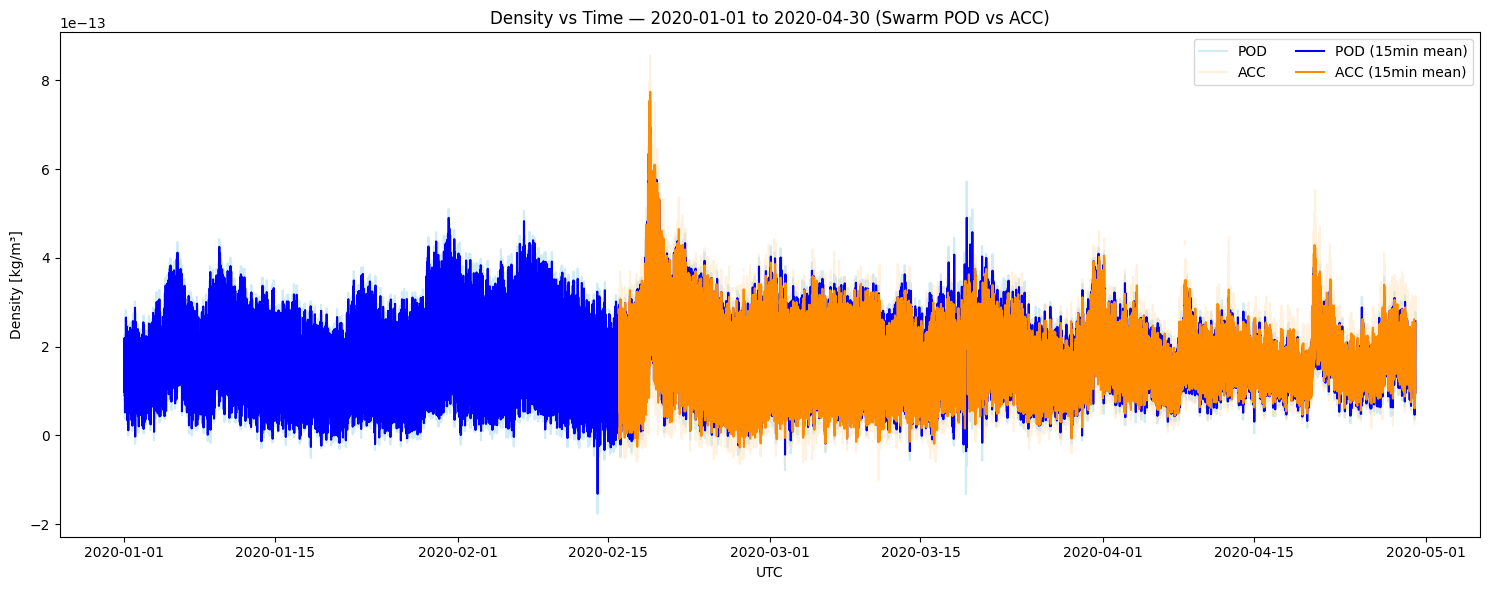

In [126]:

# 期間を指定（文字列でも date でもOK）
start, end = "2020-01-01", "2020-04-30"
# start, end = date(2020,1,1), date(2020,4,30)

# DNSを 1〜4月分に結合（必要列だけ取ると軽くなります）
P_all = concat_dns_range(DNS_POD, start, end, cols=["density"]).rename(columns={"density":"rho_pod"})
A_all = concat_dns_range(DNS_ACC, start, end, cols=["density"]).rename(columns={"density":"rho_acc"})

# 念のためのガード
if P_all.empty or A_all.empty:
    raise ValueError("指定期間にデータがありません（POD/ACCのどちらかが空）")

# PODを基準にACCを時間合わせ（±30秒）
merged = pd.merge_asof(
    P_all.sort_index()[["rho_pod"]],
    A_all.sort_index()[["rho_acc"]],
    left_index=True, right_index=True,
    direction="nearest", tolerance=pd.Timedelta("30s")
)

# 15分移動平均で平滑化
mv = merged.rolling("15min", min_periods=1).mean()

# === プロット ===
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(merged.index, merged["rho_pod"], color="skyblue", alpha=0.4, label="POD")
ax.plot(merged.index, merged["rho_acc"], color="navajowhite", alpha=0.4, label="ACC")
ax.plot(mv.index,     mv["rho_pod"],     color="blue",      label="POD (15min mean)")
ax.plot(mv.index,     mv["rho_acc"],     color="darkorange",label="ACC (15min mean)")
ax.set_title(f"Density vs Time — {pd.to_datetime(start).date()} to {pd.to_datetime(end).date()} (Swarm POD vs ACC)")
ax.set_ylabel("Density [kg/m³]")
ax.set_xlabel("UTC")
ax.legend(ncol=2)
plt.tight_layout(); plt.show()



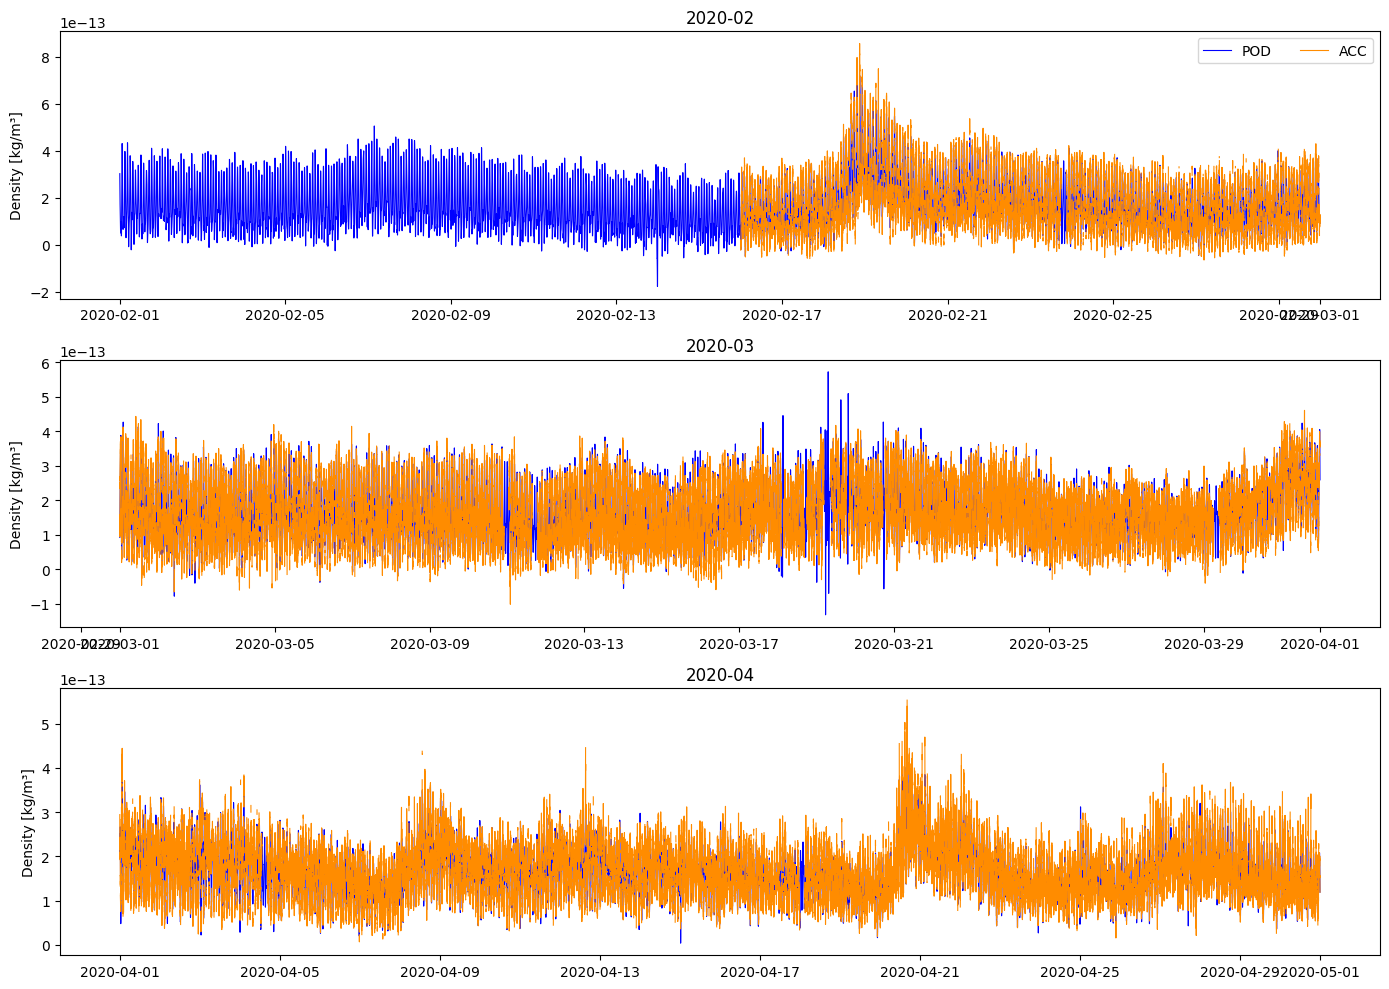

In [121]:

def concat_dns_month(DNS, y, m):
    start = pd.Timestamp(y, m, 1)
    end   = (start + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    frames=[]
    for k in sorted(DNS.keys()):
        df = DNS[k]["data"]
        if not df.empty:
            cut = df.loc[start:end]
            if not cut.empty: frames.append(cut)
    return pd.concat(frames).sort_index() if frames else pd.DataFrame()

fig, axes = plt.subplots(3, 1, figsize=(14,10), sharex=False)
for i, m in enumerate([2,3,4]):
    P = concat_dns_month(DNS_POD, 2020, m).rename(columns={"density":"rho_pod"})
    A = concat_dns_month(DNS_ACC, 2020, m).rename(columns={"density":"rho_acc"})
    if P.empty or A.empty:
        axes[i].set_title(f"2020-{m:02d} (no data)"); continue
    
    M = pd.merge_asof(P[["rho_pod"]].sort_index(),
                        A[["rho_acc"]].sort_index(),
                        left_index=True, right_index=True,
                        direction="nearest", tolerance=pd.Timedelta("30s"))
    
# 生データのみプロット
    axes[i].plot(M.index, M["rho_pod"], color="blue",  linewidth=0.8, label="POD")
    axes[i].plot(M.index, M["rho_acc"], color="darkorange", linewidth=0.8, label="ACC")

    axes[i].set_ylabel("Density [kg/m³]")
    axes[i].set_title(f"2020-{m:02d}")
    if i==0: axes[i].legend(ncol=2)

plt.tight_layout()
plt.show()


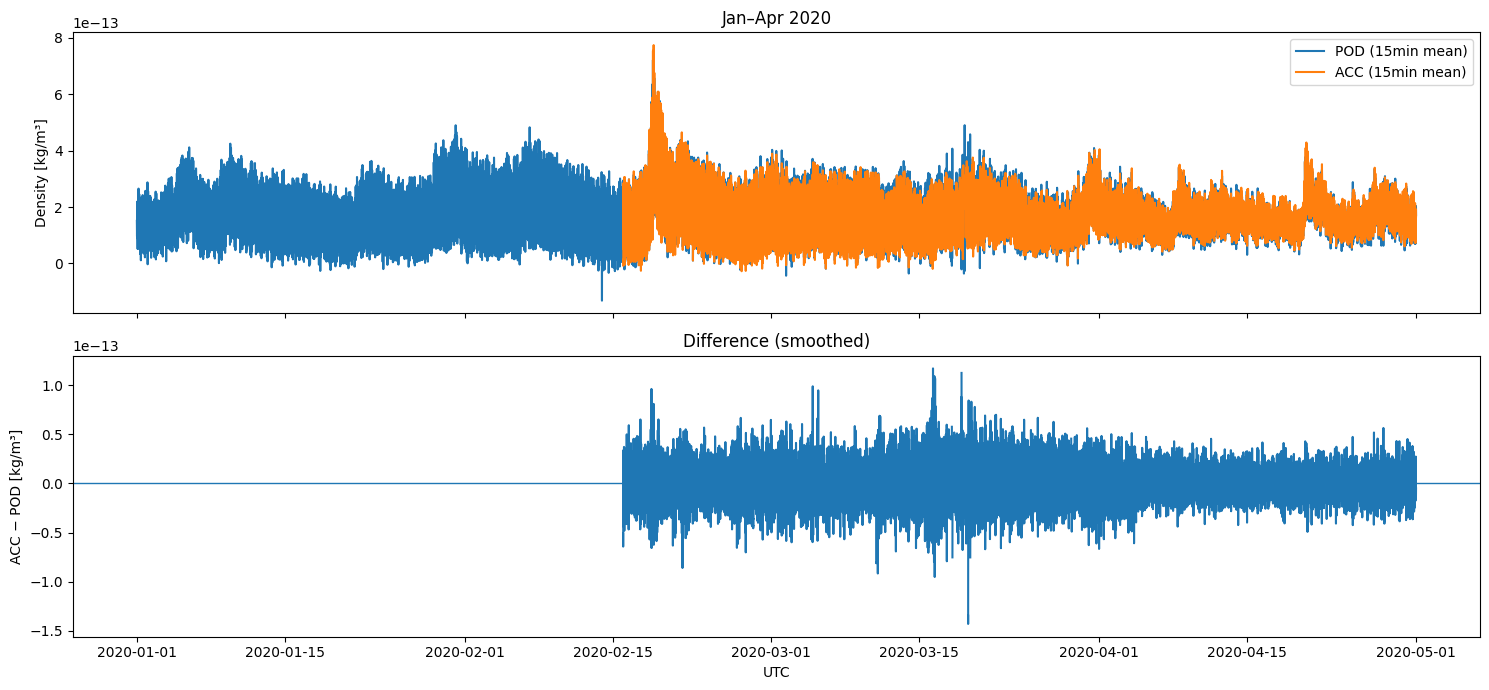

In [127]:
def concat_dns(DNS):
    frames=[DNS[k]["data"] for k in sorted(DNS.keys()) if not DNS[k]["data"].empty]
    return pd.concat(frames).sort_index()

P = concat_dns(DNS_POD).loc["2020-01-01":"2020-04-30"].rename(columns={"density":"rho_pod"})
A = concat_dns(DNS_ACC).loc["2020-01-01":"2020-04-30"].rename(columns={"density":"rho_acc"})
M = pd.merge_asof(P[["rho_pod"]].sort_index(),
                  A[["rho_acc"]].sort_index(),
                  left_index=True, right_index=True,
                  direction="nearest", tolerance=pd.Timedelta("30s"))
mv = M.rolling("15min", min_periods=1).mean()
diff = mv["rho_acc"] - mv["rho_pod"]     # 差分（必要なら比率: mv["rho_acc"]/mv["rho_pod"]）

fig, axes = plt.subplots(2,1,figsize=(15,7), sharex=True)
axes[0].plot(mv.index, mv["rho_pod"], label="POD (15min mean)")
axes[0].plot(mv.index, mv["rho_acc"], label="ACC (15min mean)")
axes[0].set_ylabel("Density [kg/m³]"); axes[0].set_title("Jan–Apr 2020")
axes[0].legend()

axes[1].plot(diff.index, diff)
axes[1].axhline(0, linewidth=1)
axes[1].set_ylabel("ACC − POD [kg/m³]")
axes[1].set_xlabel("UTC"); axes[1].set_title("Difference (smoothed)")

plt.tight_layout(); plt.show()


In [23]:
# 任意変数をPOD/ACCで同じ月に重ね描き
def plot_var_months(DNS_POD, DNS_ACC, year, months, var='density', label=None, scale=1.0,
                    tolerance='30s'):
    fig, axes = plt.subplots(len(months), 1, figsize=(14, 3.2*len(months)), sharex=False)
    if len(months) == 1:
        axes = [axes]
    for i, m in enumerate(months):
        P = concat_dns_month(DNS_POD, year, m)
        A = concat_dns_month(DNS_ACC, year, m)
        if P.empty or A.empty or (var not in P.columns) or (var not in A.columns):
            axes[i].set_title(f"{year}-{m:02d} (no data)"); axes[i].set_ylabel(label or var); continue

        # 列名をPOD/ACCで分けておく
        P = P[[var]].rename(columns={var: f'{var}_pod'}).sort_index()
        A = A[[var]].rename(columns={var: f'{var}_acc'}).sort_index()

        M = pd.merge_asof(P, A, left_index=True, right_index=True,
                          direction="nearest", tolerance=pd.Timedelta(tolerance))

        # スケール（例：density×1e13, altitude×1e-3 など）
        if scale != 1.0:
            M = M * scale

        axes[i].plot(M.index, M[f'{var}_pod'], color="blue", linewidth=0.8, label="POD")
        axes[i].plot(M.index, M[f'{var}_acc'], color="darkorange", linewidth=0.8, label="ACC")
        axes[i].set_title(f"{year}-{m:02d}")
        axes[i].set_ylabel(label or var)
        if i == 0:
            axes[i].legend(ncol=2)

    plt.tight_layout()
    plt.show()


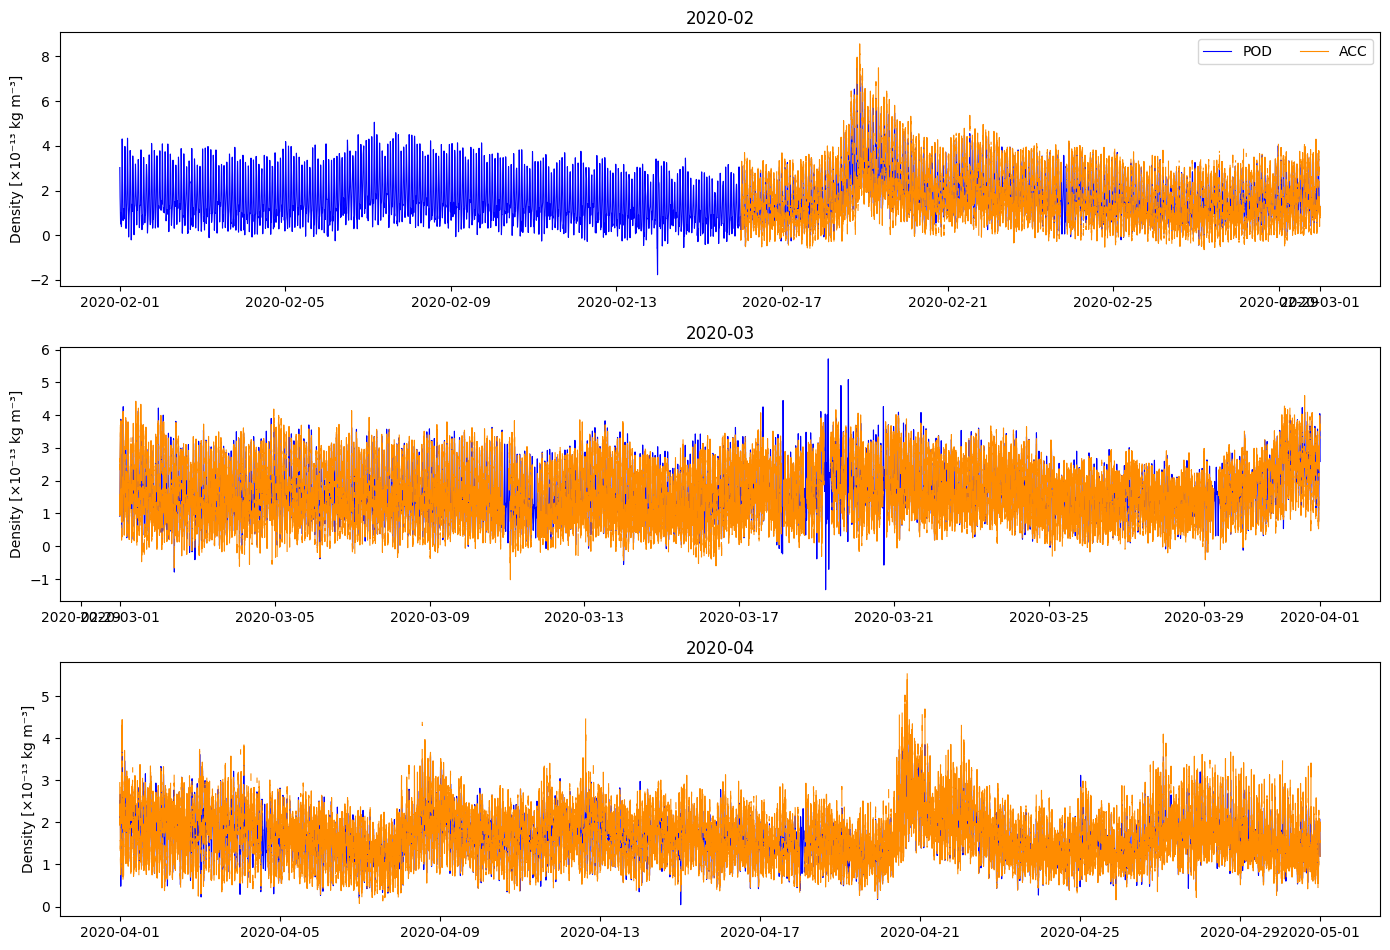

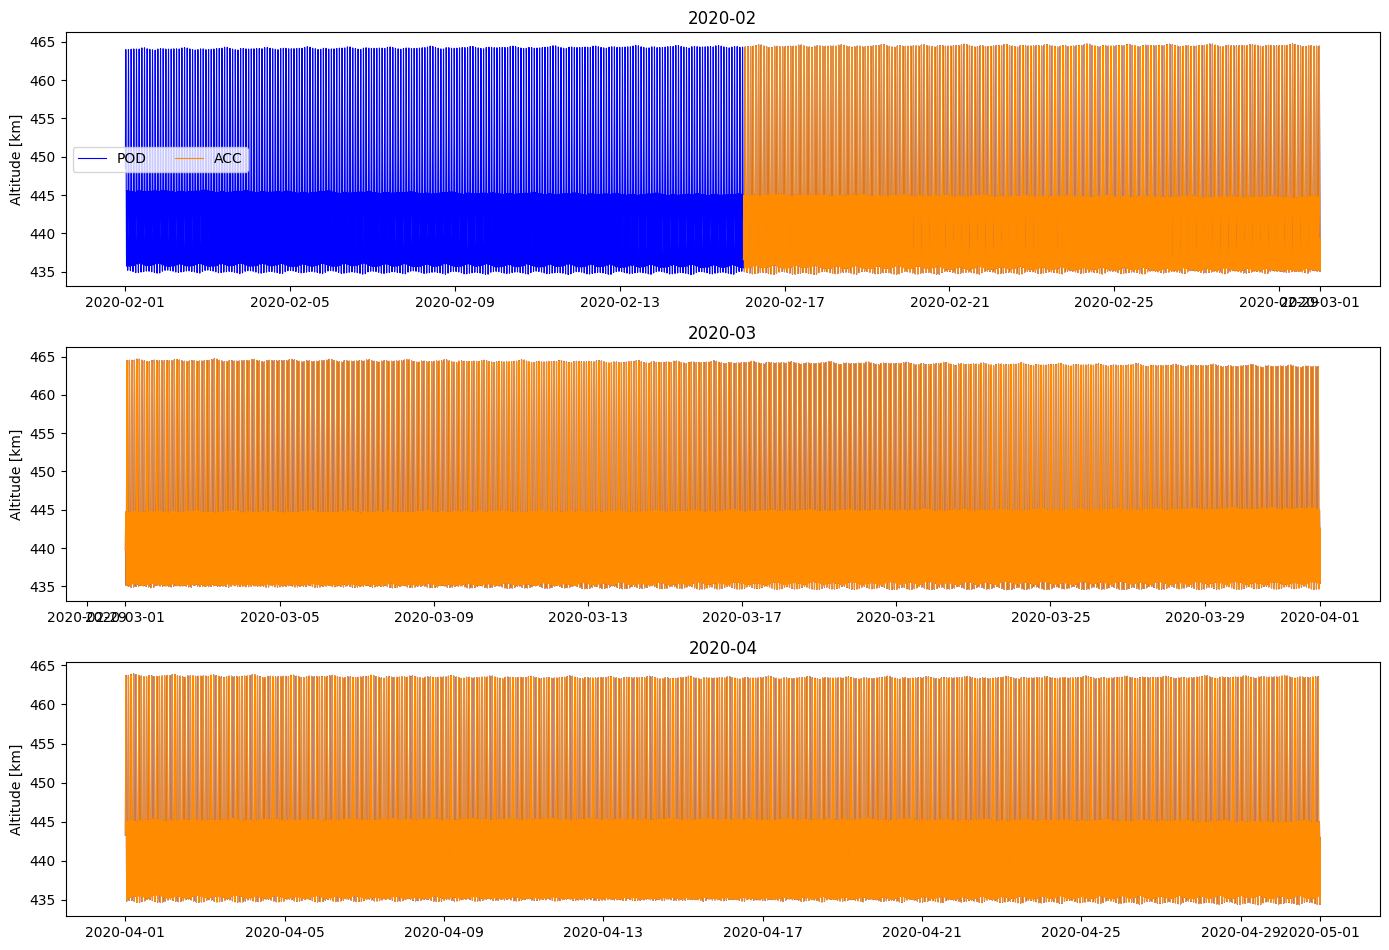

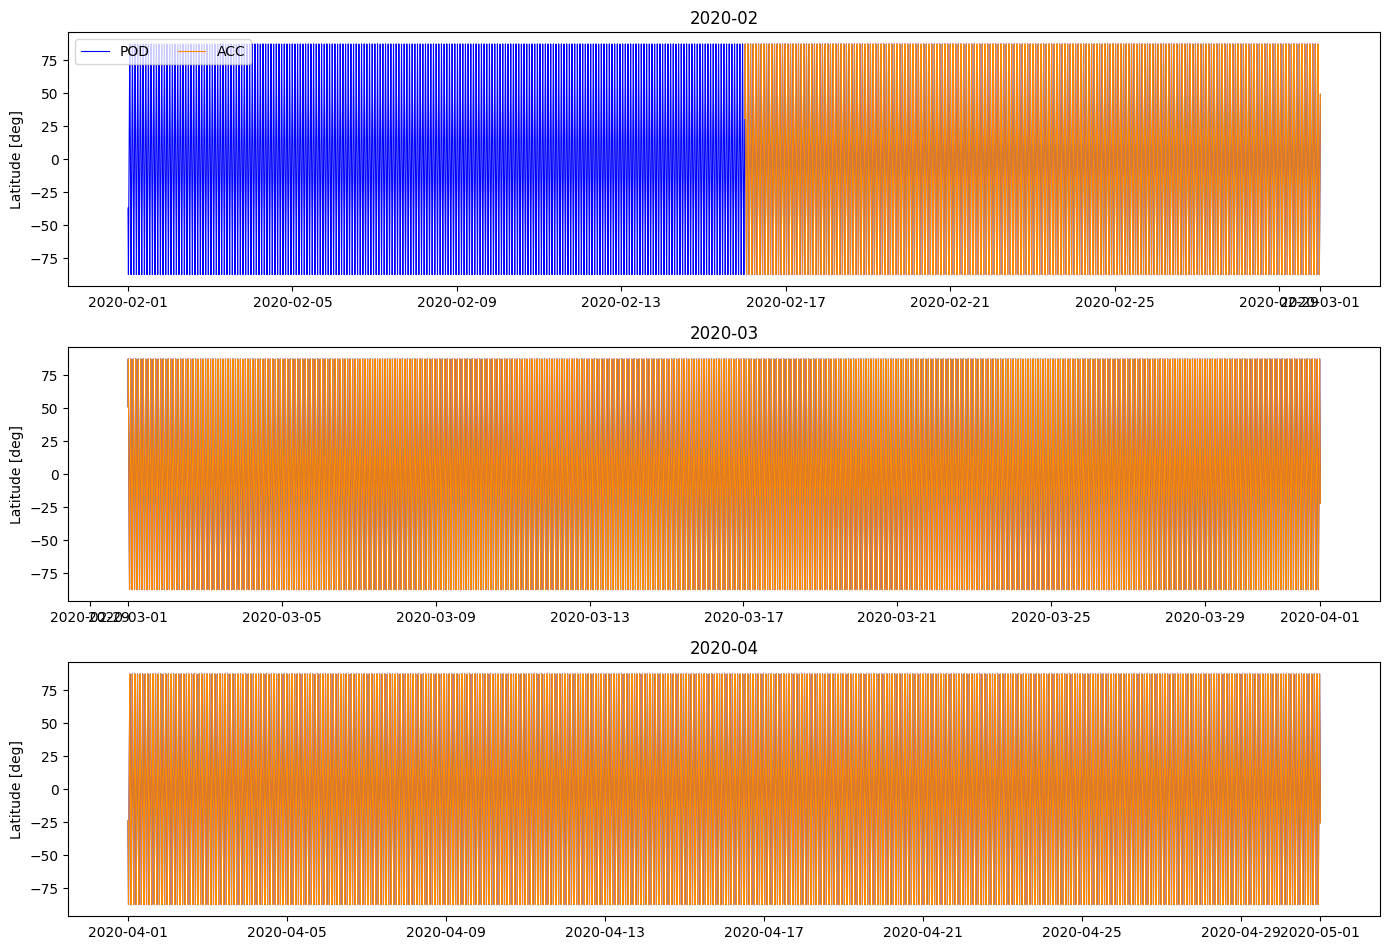

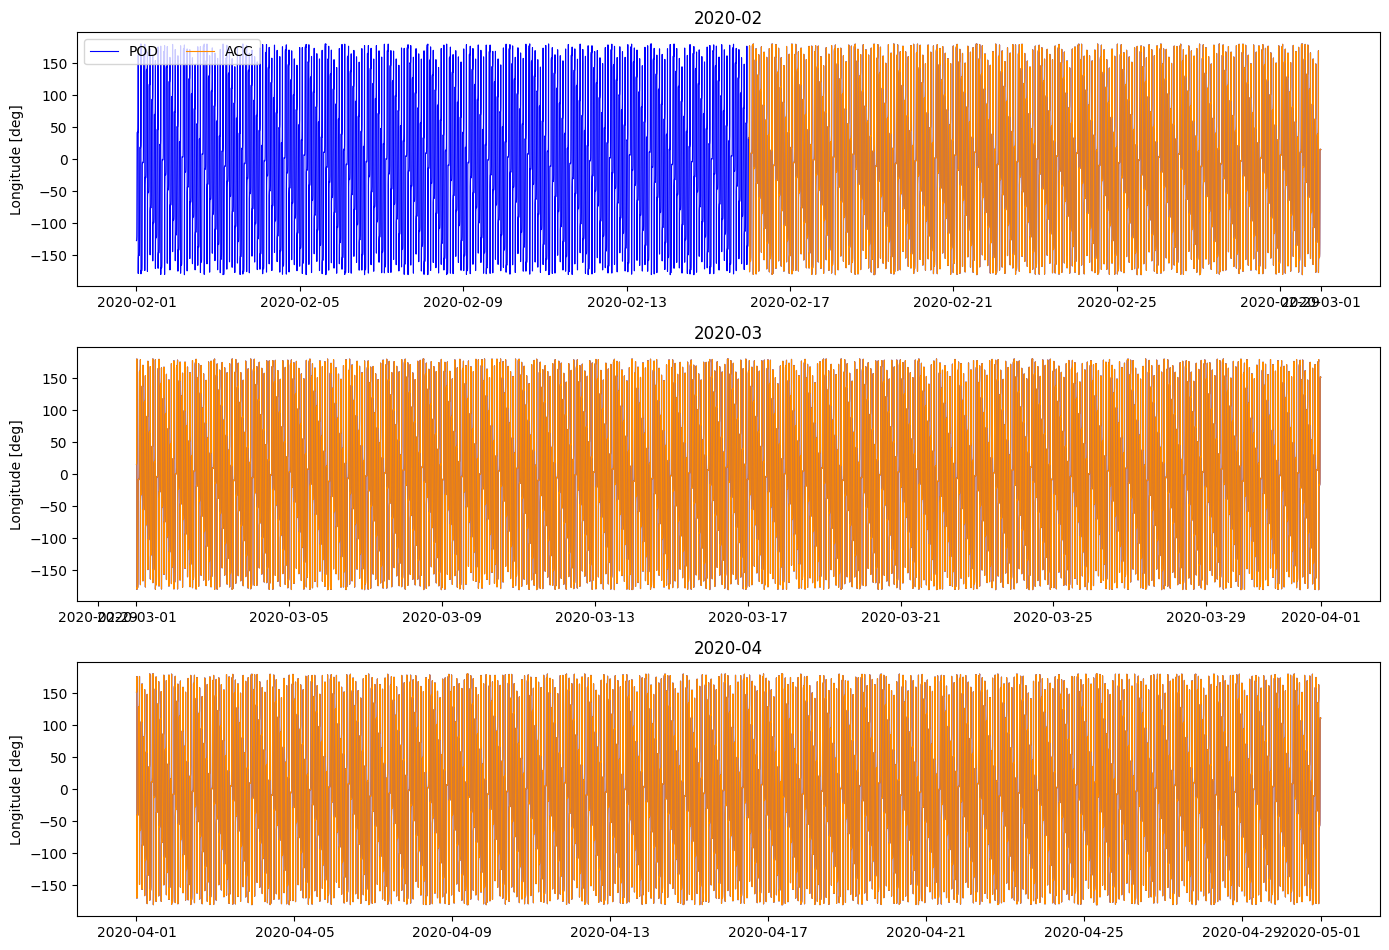

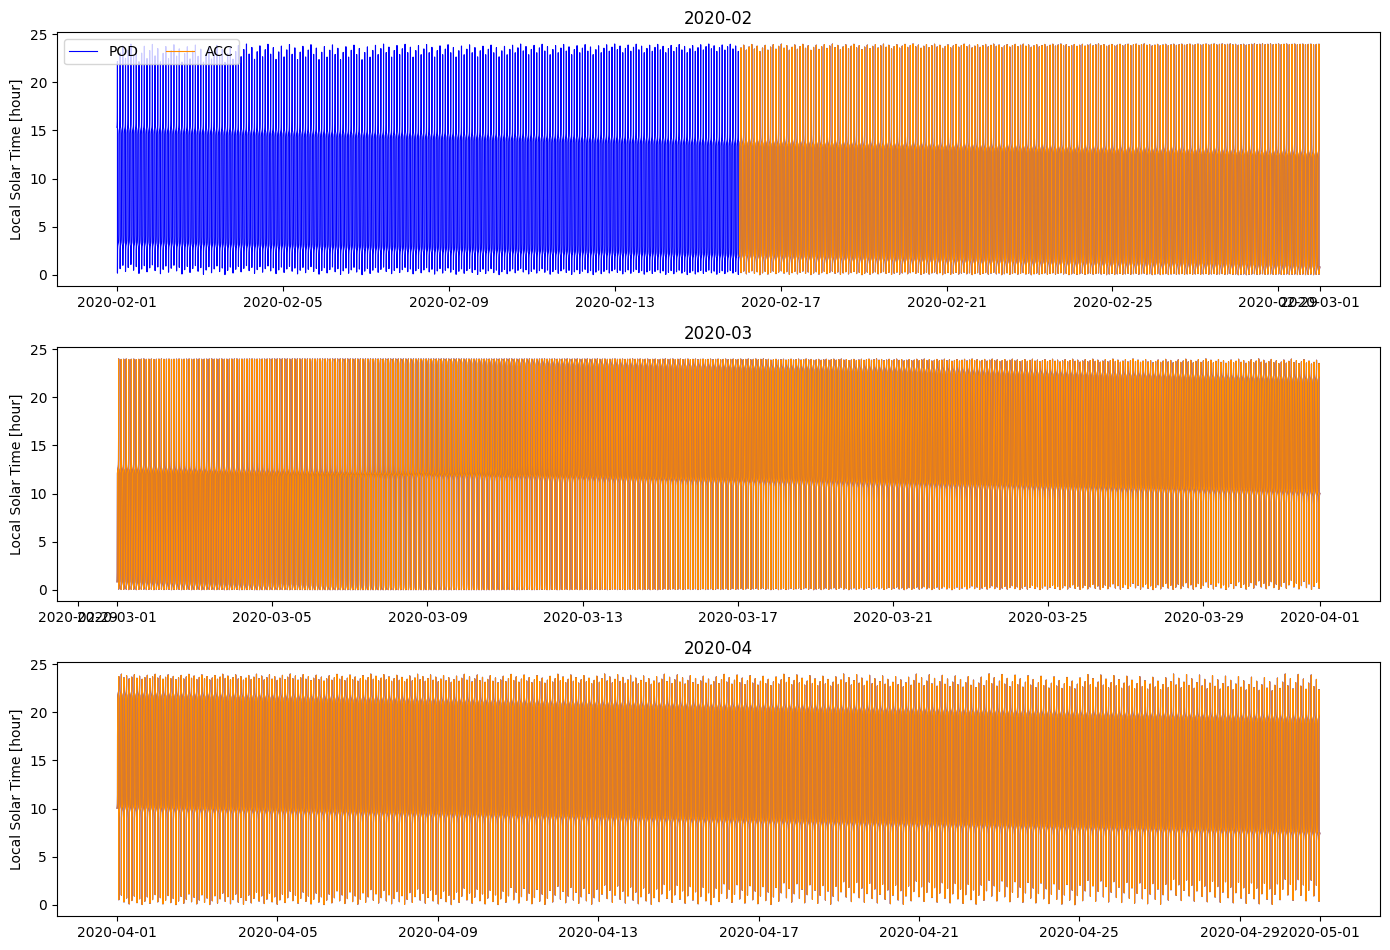

In [24]:
# 1) これまで通り density（単位を×10^-13表示したい場合）
plot_var_months(DNS_POD, DNS_ACC, 2020, [2,3,4],
                var='density', label='Density [×10⁻¹³ kg m⁻³]', scale=1e13)

# 2) 高度（m→km にしたい）
plot_var_months(DNS_POD, DNS_ACC, 2020, [2,3,4],
                var='altitude', label='Altitude [km]', scale=1e-3)

# 3) 緯度・経度（スケール不要）
plot_var_months(DNS_POD, DNS_ACC, 2020, [2,3,4],
                var='latitude',  label='Latitude [deg]')
plot_var_months(DNS_POD, DNS_ACC, 2020, [2,3,4],
                var='longitude', label='Longitude [deg]')

# 4) Local solar time（そのまま）
plot_var_months(DNS_POD, DNS_ACC, 2020, [2,3,4],
                var='local_solar_time', label='Local Solar Time [hour]')


In [128]:
# 日付→DOY（2020年基準の例。必要なら汎用化してね）
def doy_2020(d: date) -> int:
    return (d - date(2020,1,1)).days + 1

def day_slice(df: pd.DataFrame, d: date):
    start = pd.Timestamp(d.year, d.month, d.day)
    end   = start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    return df.loc[start:end]

def plot_var_days(DNS_POD, DNS_ACC, dates, var='density', label=None, scale=1.0,
                  tolerance='30s', resample=None):
    fig, axes = plt.subplots(len(dates), 1, figsize=(14, 3.2*len(dates)), sharex=False)
    if len(dates) == 1:
        axes = [axes]

    for i, d in enumerate(dates):
        k = doy_2020(d)
        P = DNS_POD.get(k, {}).get("data", pd.DataFrame())
        A = DNS_ACC.get(k, {}).get("data", pd.DataFrame())

        if P is None or A is None or P.empty or A.empty or (var not in P.columns) or (var not in A.columns):
            axes[i].set_title(f"{d.isoformat()} (no data)")
            axes[i].set_ylabel(label or var)
            continue

        P = day_slice(P, d)[[var]].rename(columns={var: f'{var}_pod'}).sort_index()
        A = day_slice(A, d)[[var]].rename(columns={var: f'{var}_acc'}).sort_index()

        if resample:
            P = P.resample(resample).mean()
            A = A.resample(resample).mean()

        M = pd.merge_asof(P, A, left_index=True, right_index=True,
                          direction="nearest", tolerance=pd.Timedelta(tolerance))

        if scale != 1.0:
            M = M * scale

        axes[i].plot(M.index, M[f'{var}_pod'], color="blue", linewidth=0.9, label="POD")
        axes[i].plot(M.index, M[f'{var}_acc'], color="darkorange", linewidth=0.9, label="ACC")
        axes[i].set_title(d.isoformat())
        axes[i].set_ylabel(label or var)
        if i == 0:
            axes[i].legend(ncol=2)

    plt.tight_layout()
    plt.show()

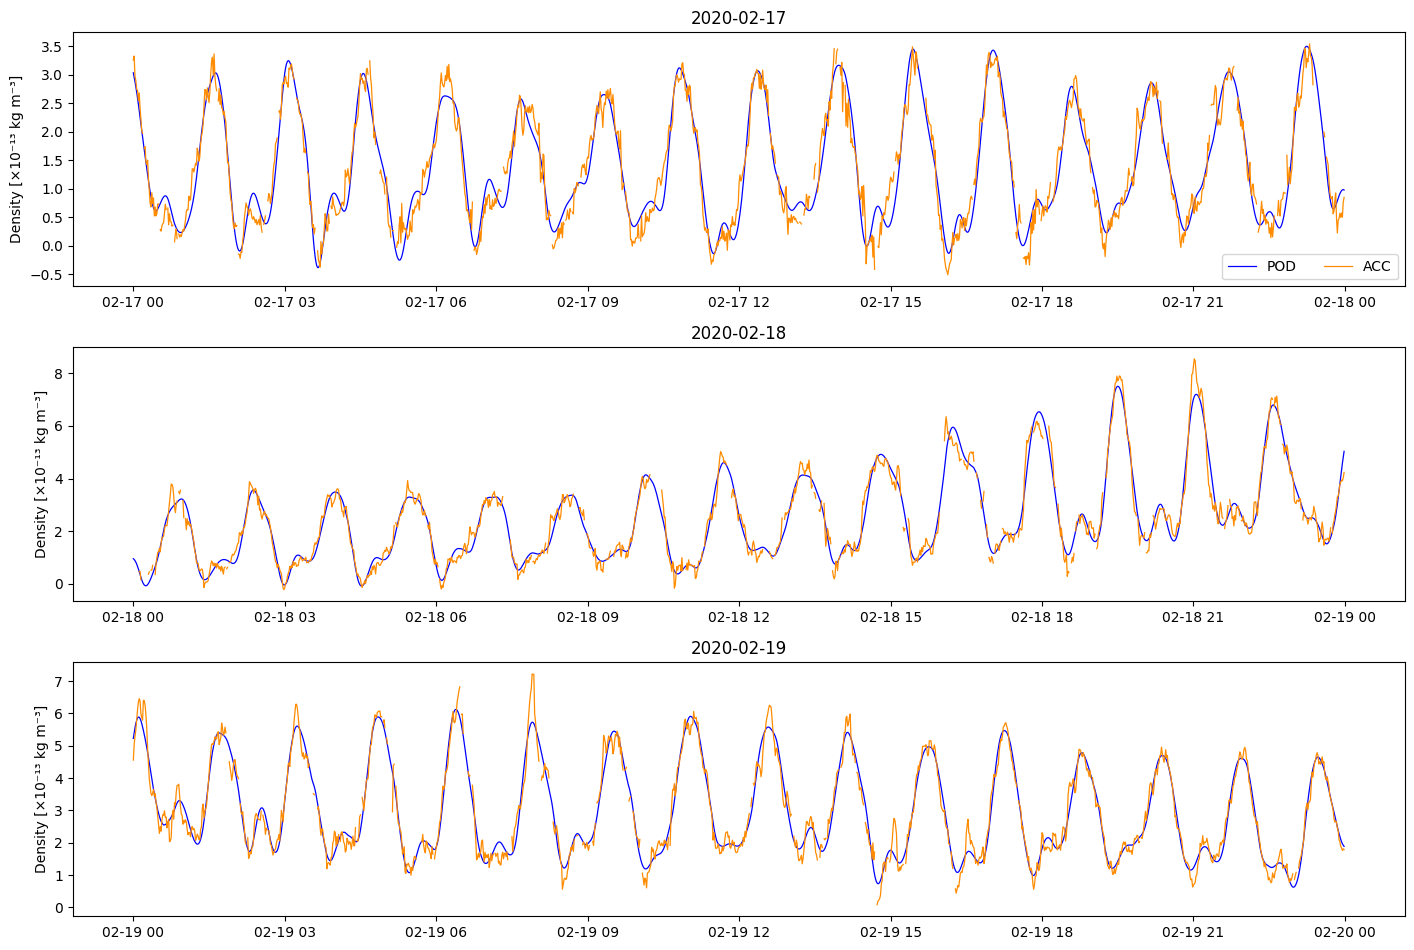

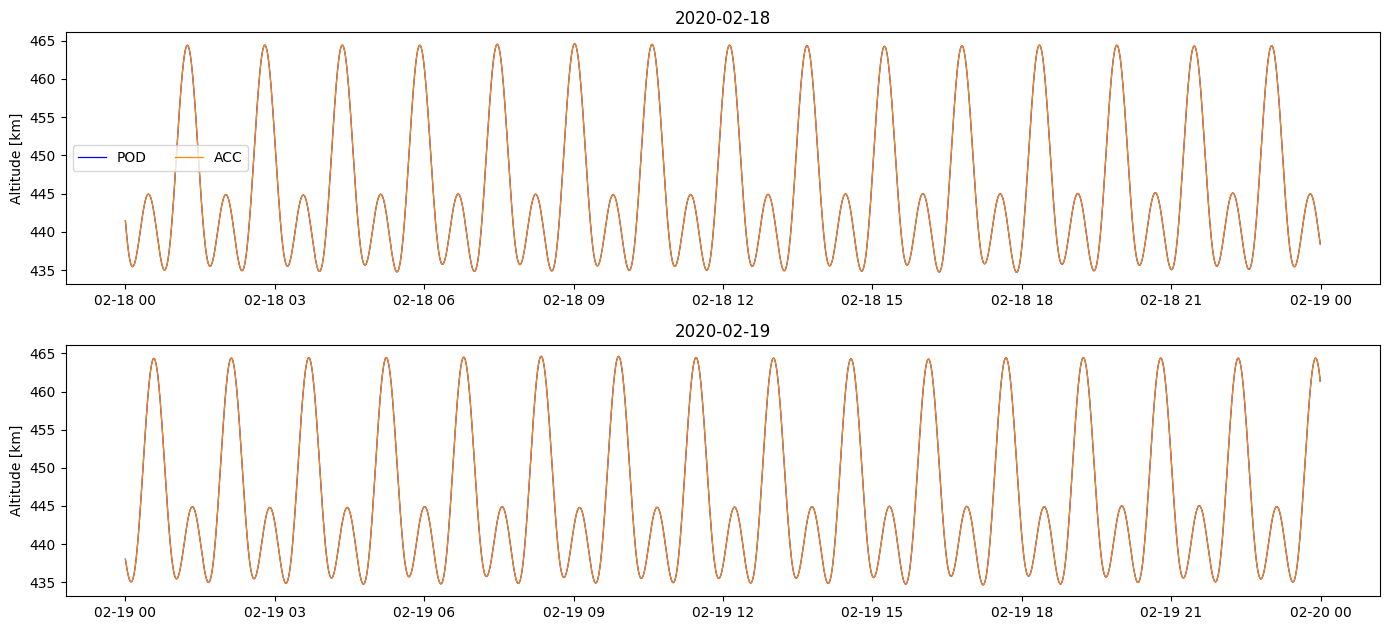

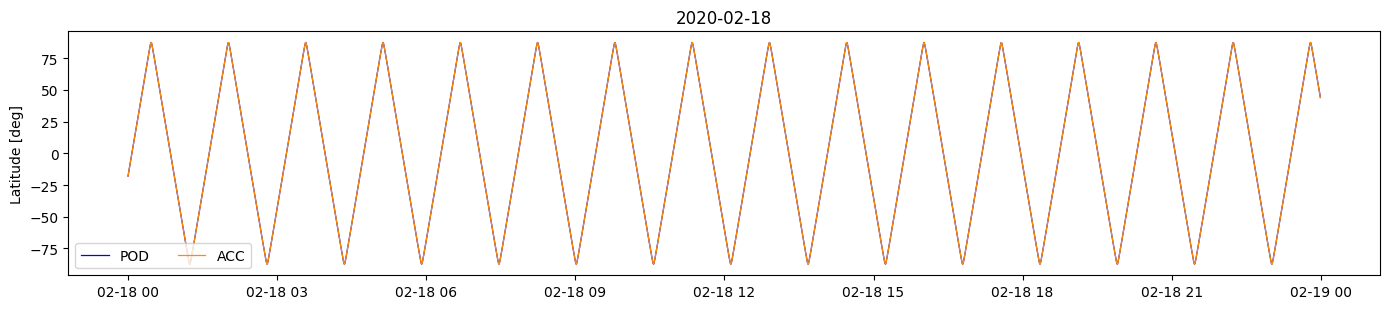

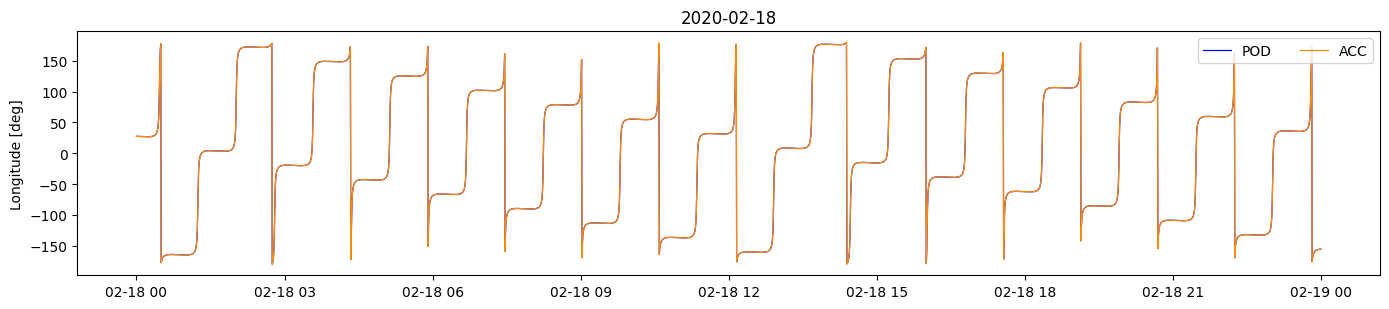

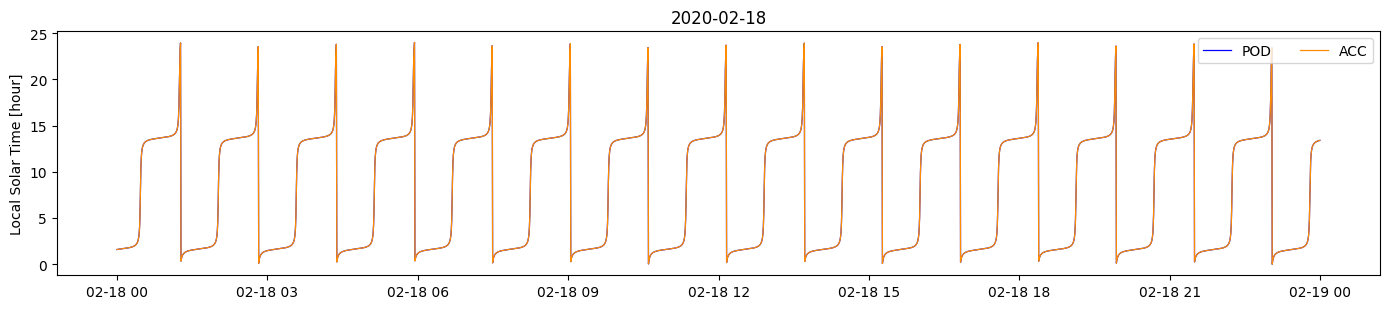

In [129]:

# 1) density（×10^-13 表示）
plot_var_days(DNS_POD, DNS_ACC,
              dates=[date(2020,2,17), date(2020,2,18), date(2020,2,19)],
              var='density', label='Density [×10⁻¹³ kg m⁻³]', scale=1e13,
              tolerance='30s', resample='1min')  # resampleは任意

# 2) 高度（m→km）
plot_var_days(DNS_POD, DNS_ACC,
              dates=[date(2020,2,18), date(2020,2,19)],
              var='altitude', label='Altitude [km]', scale=1e-3,
              tolerance='30s')

# 3) 緯度・経度・地方時
plot_var_days(DNS_POD, DNS_ACC, [date(2020,2,18)], var='latitude', label='Latitude [deg]')
plot_var_days(DNS_POD, DNS_ACC, [date(2020,2,18)], var='longitude', label='Longitude [deg]')
plot_var_days(DNS_POD, DNS_ACC, [date(2020,2,18)], var='local_solar_time', label='Local Solar Time [hour]')


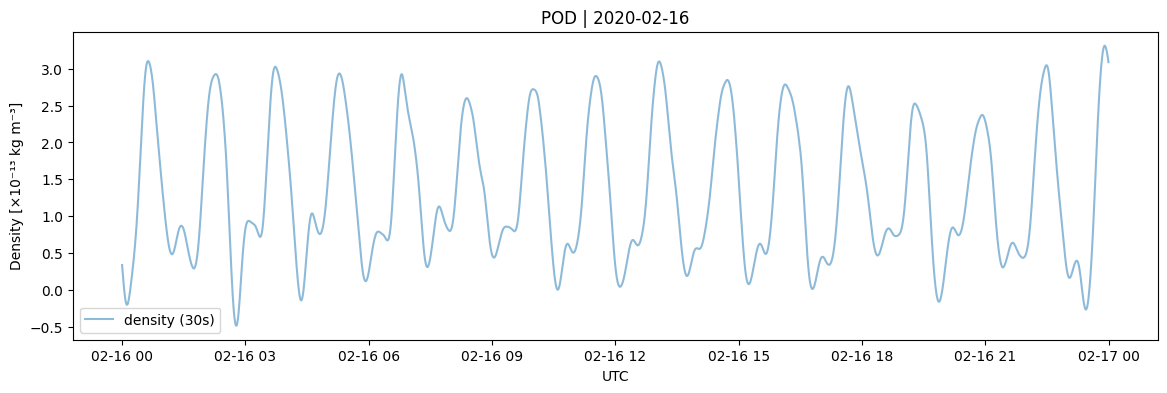

In [27]:
def plot_orbitmean_day(DNS_POD, d: date, scale=1e13):
    k = (d - date(2020,1,1)).days + 1   # doy_2020 と同じ計算
    df = DNS_POD.get(k, {}).get("data", None)
    if df is None or df.empty:
        print(f"No data on {d}"); return

    fig, ax = plt.subplots(figsize=(14,4))
    ax.plot(df.index, df["density"]*scale, alpha=0.5, label="density (30s)")
    if "density_orbitmean" in df.columns:
        ax.plot(df.index, df["density_orbitmean"]*scale, color="red", lw=1.2,
                label="density_orbitmean (orbit-avg)")
    ax.set_ylabel("Density [×10⁻¹³ kg m⁻³]")
    ax.set_xlabel("UTC")
    ax.set_title(f"POD | {d.isoformat()}")
    ax.legend()
    plt.show()

# 例: 2020年2月16日
plot_orbitmean_day(DNS_POD, date(2020,2,16))

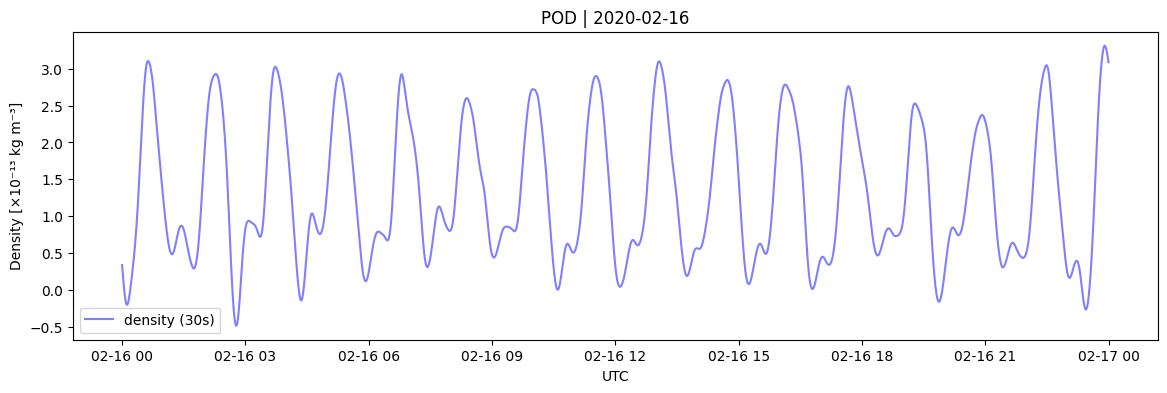

In [29]:

def plot_orbitmean_day(DNS_POD, d: date, scale=1e13):
    # DOY計算（2020年専用）
    k = (d - date(2020,1,1)).days + 1
    df = DNS_POD.get(k, {}).get("data", None)
    if df is None or df.empty:
        print(f"No data on {d}"); return

    fig, ax = plt.subplots(figsize=(14,4))
    # 青：瞬間のPOD密度（30秒刻み）
    ax.plot(df.index, df["density"]*scale, alpha=0.5, color="blue",
            label="density (30s)")
    # 赤：軌道平均（約90分の平滑化）
    if "density_orbitmean" in df.columns:
        ax.plot(df.index, df["density_orbitmean"]*scale,
                color="red", lw=1.2, label="density_orbitmean (orbit-avg)")
    ax.set_ylabel("Density [×10⁻¹³ kg m⁻³]")
    ax.set_xlabel("UTC")
    ax.set_title(f"POD | {d.isoformat()}")
    ax.legend()
    plt.show()

# 例：2020年2月16日
plot_orbitmean_day(DNS_POD, date(2020,2,16))


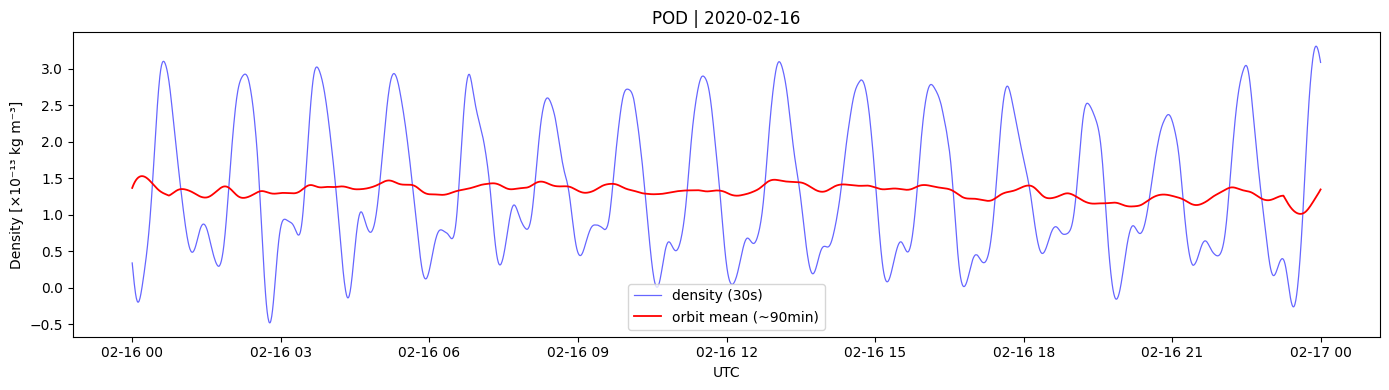

In [31]:

def orbit_mean(series: pd.Series, window='90min'):
    # 時間ベースrolling（欠損があってもOK）。中心窓で滑らかに
    return series.rolling(window=window, min_periods=1, center=True).mean()

def plot_pod_density_with_orbitmean_day(DNS_POD, d: date, scale=1e13, window='90min'):
    k = (d - date(2020,1,1)).days + 1
    df = DNS_POD.get(k, {}).get("data", pd.DataFrame())
    if df.empty or 'density' not in df.columns:
        print(f"No data on {d}"); return

    y = df['density'] * scale
    y_orb = orbit_mean(y, window=window)

    fig, ax = plt.subplots(figsize=(14,4))
    ax.plot(df.index, y,        color="blue", alpha=0.6, linewidth=0.9, label="density (30s)")
    ax.plot(df.index, y_orb,    color="red",  linewidth=1.3,            label=f"orbit mean (~{window})")
    ax.set_ylabel("Density [×10⁻¹³ kg m⁻³]")
    ax.set_xlabel("UTC")
    ax.set_title(f"POD | {d.isoformat()}")
    ax.legend()
    plt.tight_layout(); plt.show()

# 例：2020-02-16
plot_pod_density_with_orbitmean_day(DNS_POD, date(2020,2,16))
